In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim as optim
from torch.nn.functional import sigmoid
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import random
from torch.utils.data import Dataset, DataLoader

In [6]:
DAYS = 1
MAX_WBC = 64

In [7]:
lab_data = pd.read_csv("/home/jupyter-juiyun/Digital_Health/data/combined_lab_data.csv")
test_list = pd.read_csv("/home/jupyter-juiyun/Digital_Health/test.csv")['file_name']
len(test_list)

615

In [8]:
train = lab_data[lab_data['file_name'].isin(test_list) == False]
test = lab_data[lab_data['file_name'].isin(test_list)]
columns_train = train[['file_name', 'event[all-cause mortality]', 'time[all-cause mortality]']].copy().dropna()
columns_test = test[['file_name', 'event[all-cause mortality]', 'time[all-cause mortality]']].copy().dropna()
len(columns_train), len(columns_test)

(12687, 605)

In [9]:
# lab_data_train = pd.read_csv('/home/jupyter-juiyun/Digital_Health/data/lab_data_train.csv')
# lab_data_test = pd.read_csv('/home/jupyter-juiyun/Digital_Health/data/lab_data_test.csv')

# columns_train = lab_data_train[['file_name', 'event[all-cause mortality]', 'time[all-cause mortality]']].copy().dropna()
# columns_test = lab_data_test[['file_name', 'event[all-cause mortality]', 'time[all-cause mortality]']].copy().dropna()
# len(columns_train), len(columns_test)

In [10]:
os.chdir('/home/jupyter-juiyun/Digital_Health/data/')
PBS_filenames = os.listdir('PBS_resnet')
WBC_filenames = os.listdir('WBC_resnet')
len(PBS_filenames), len(WBC_filenames)

(16193, 968083)

In [11]:
PBS_filenames = [f[:-3] for f in PBS_filenames]

temp_WBC = set()
for i in WBC_filenames:
    temp_WBC.add(i.split('_')[0])
len(temp_WBC)

columns_train = columns_train[columns_train['file_name'].str[:-4].isin(PBS_filenames) & columns_train['file_name'].str[:10].isin(temp_WBC)]
columns_test = columns_test[columns_test['file_name'].str[:-4].isin(PBS_filenames) & columns_test['file_name'].str[:10].isin(temp_WBC)]
columns_train.reset_index(drop=True, inplace=True)
columns_test.reset_index(drop=True, inplace=True)
print("number of datas with both WBC and PBS in train set:", len(columns_train))
print("number of datas with both WBC and PBS in test set:", len(columns_test))

number of datas with both WBC and PBS in train set: 5036
number of datas with both WBC and PBS in test set: 570


In [12]:
def mortality_in_days(df_data, days):
    file_names = []
    labels = []

    for i in range(len(df_data)):
        file_name = df_data['file_name'][i]
        event = df_data['event[all-cause mortality]'][i]
        time = df_data['time[all-cause mortality]'][i]

        if time <= days:
            if event == 1:
                file_names.append(file_name)
                labels.append(1)

        else:
            file_names.append(file_name)
            labels.append(0)

    result = pd.DataFrame({'file_name': file_names, 'label': labels})
    return result

In [13]:

data_train = mortality_in_days(columns_train, DAYS)
data_val = mortality_in_days(columns_test, DAYS)

In [14]:
print('data_train')
print('total:', len(data_train))
print(data_train['label'].value_counts())
print()

print('data_val')
print('total:', len(data_val))
print(data_val['label'].value_counts())

data_train
total: 4970
label
0    4817
1     153
Name: count, dtype: int64

data_val
total: 567
label
0    546
1     21
Name: count, dtype: int64


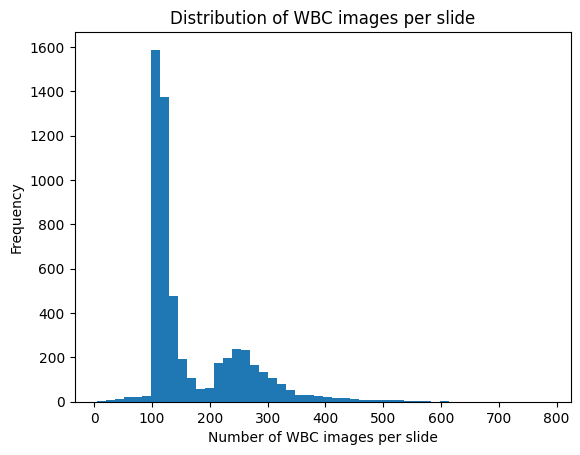

In [15]:
slideid_to_WBC = {}
for i in data_train['file_name']:
    slideid_to_WBC[i.split('_')[0]] = []
for i in data_val['file_name']:
    slideid_to_WBC[i.split('_')[0]] = []

for i in WBC_filenames:
    slidenum = i.split('_')[0]
    if slidenum in slideid_to_WBC:
        slideid_to_WBC[slidenum].append(i)

freq = [len(slideid_to_WBC[v]) for v in slideid_to_WBC]
# draw a histogram of the frequency
import matplotlib.pyplot as plt
plt.hist(freq, bins=50)
plt.xlabel('Number of WBC images per slide')
plt.ylabel('Frequency')
plt.title('Distribution of WBC images per slide')
plt.show()

In [16]:
# --- Config ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_DIM = 2048

In [17]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.classifier = nn.Linear(input_dim, 1)

    def forward(self, bag):
        # bag: (num_instances, input_dim)
        attention_weights = self.attention(bag)  # (num_instances, 1)
        attention_weights = torch.softmax(attention_weights, dim=0)  # Normalize
        weighted_avg = torch.sum(attention_weights * bag, dim=0)  # (input_dim,)
        out = self.classifier(weighted_avg)
        return out.squeeze(), attention_weights.squeeze()

In [18]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from PIL import UnidentifiedImageError




class PBSBagDataset(Dataset):
    def __init__(self, df, pbs_dir = "PBS_resnet", wbc_dir = "WBC_resnet", transform=None, wbc_transform=None):
        """
        df: DataFrame with columns ['file_name', 'label']
        pbs_dir: Directory containing PBS images
        wbc_dir: Directory containing WBC images
        transform: Transformations for PBS images
        wbc_transform: Transformations for WBC images (optional, defaults to transform)
        """
        self.labels_df = df
        self.pbs_dir = pbs_dir
        self.wbc_dir = wbc_dir
        self.transform = transform
        self.wbc_transform = wbc_transform if wbc_transform is not None else transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):

        label = int(self.labels_df.iloc[idx, 1])

        # Load PBS embedding from .pt file
        pbs_name = self.labels_df.iloc[idx, 0]
        pbs_pt_name = pbs_name.replace('.jpg', '.pt').replace('.png', '.pt')
        pbs_pt_path = os.path.join(self.pbs_dir, pbs_pt_name)
        pbs_embedding = torch.load(pbs_pt_path)

        # load WBC embeddings from .pt files
        wbc_embeddings = []
        wbc_img_names = slideid_to_WBC[pbs_pt_name.split('_')[0]]
        if len(wbc_img_names) > MAX_WBC:
            wbc_img_names = random.sample(wbc_img_names, MAX_WBC)
        for wbc_img_name in wbc_img_names:
            wbc_pt_name = wbc_img_name.replace('.jpg', '.pt').replace('.png', '.pt')
            wbc_pt_path = os.path.join(self.wbc_dir, wbc_pt_name)
            try:
                emb = torch.load(wbc_pt_path)
                wbc_embeddings.append(emb)
            except Exception:
                continue  # Skip if embedding file is missing or corrupted

        if len(wbc_embeddings) == 0:
            # If all WBC embeddings are invalid, skip this sample
            return self.__getitem__((idx + 1) % len(self))

        wbc_embeddings = torch.stack(wbc_embeddings)  # (n, embed_dim)

        return pbs_embedding, wbc_embeddings, label

In [19]:
# ----- Data Preparation -----
train_dataset = PBSBagDataset(data_train)
val_dataset = PBSBagDataset(data_val,)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

In [20]:

mil_model = AttentionMIL(input_dim=EMBED_DIM * 2).to(DEVICE)  # input_dim is now PBS + WBC embedding
optimizer = torch.optim.Adam(mil_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10

for epoch in range(num_epochs):
    # ========== Training ==========
    mil_model.train()
    running_train_loss = 0.0

    for pbs_embedding, wbc_embeddings, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
        # wbc_embeddings: (n, EMBED_DIM), batch_size=1
        pbs_embedding = pbs_embedding[0].to(DEVICE)  # (EMBED_DIM,)
        wbc_embeddings = wbc_embeddings[0].to(DEVICE)  # (n, EMBED_DIM)
        labels = labels.float().to(DEVICE)  # (1,)

        # Concatenate PBS embedding to each WBC embedding in the bag
        pbs_expand = pbs_embedding.unsqueeze(0).expand(wbc_embeddings.size(0), -1)  # (n, EMBED_DIM)
        bag = torch.cat([wbc_embeddings, pbs_expand], dim=1)  # (n, 2*EMBED_DIM)

        output, attn = mil_model(bag)  # output: scalar

        loss = criterion(output.unsqueeze(0), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    # ========== Validation ==========
    mil_model.eval()
    running_val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for pbs_embedding, wbc_embeddings, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation", unit="batch"):
            pbs_embedding = pbs_embedding[0].to(DEVICE)  # (EMBED_DIM,)
            wbc_embeddings = wbc_embeddings[0].to(DEVICE)  # (n, EMBED_DIM)
            labels = labels.float().to(DEVICE)  # (1,)

            pbs_expand = pbs_embedding.unsqueeze(0).expand(wbc_embeddings.size(0), -1)  # (n, EMBED_DIM)
            bag = torch.cat([wbc_embeddings, pbs_expand], dim=1)  # (n, 2*EMBED_DIM)

            output, attn = mil_model(bag)

            loss = criterion(output.unsqueeze(0), labels)
            running_val_loss += loss.item()

            val_preds.extend(torch.sigmoid(output.unsqueeze(0)).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)

    # Convert outputs to binary (0 or 1)
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
    val_labels_binary = np.array(val_labels).astype(int)

    val_accuracy = accuracy_score(val_labels_binary, val_preds_binary)
    val_f1 = f1_score(val_labels_binary, val_preds_binary)

    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss (BCE): {avg_train_loss:.4f}")
    print(f"  Val Loss (BCE):   {avg_val_loss:.4f}")
    print(f"  Val Accuracy:     {val_accuracy:.4f}")
    print(f"  Val F1 Score:     {val_f1:.4f}\n")

Epoch 1/10 - Training:   0%|          | 0/4970 [00:00<?, ?batch/s]

Epoch 1 - Validation: 100%|██████████| 567/567 [00:04<00:00, 133.57batch/s]



Epoch 1/10 Summary:
  Train Loss (BCE): 0.1245
  Val Loss (BCE):   0.1209
  Val Accuracy:     0.9630
  Val F1 Score:     0.0000



Epoch 2 - Validation: 100%|██████████| 567/567 [00:04<00:00, 139.16batch/s]



Epoch 2/10 Summary:
  Train Loss (BCE): 0.1119
  Val Loss (BCE):   0.1219
  Val Accuracy:     0.9630
  Val F1 Score:     0.0000



Epoch 3 - Validation: 100%|██████████| 567/567 [00:04<00:00, 139.11batch/s]



Epoch 3/10 Summary:
  Train Loss (BCE): 0.1090
  Val Loss (BCE):   0.1191
  Val Accuracy:     0.9630
  Val F1 Score:     0.0000



Epoch 4 - Validation: 100%|██████████| 567/567 [00:04<00:00, 141.55batch/s]



Epoch 4/10 Summary:
  Train Loss (BCE): 0.1072
  Val Loss (BCE):   0.1491
  Val Accuracy:     0.9630
  Val F1 Score:     0.0000



Epoch 5 - Validation: 100%|██████████| 567/567 [00:04<00:00, 139.84batch/s]



Epoch 5/10 Summary:
  Train Loss (BCE): 0.1066
  Val Loss (BCE):   0.1173
  Val Accuracy:     0.9594
  Val F1 Score:     0.0000



Epoch 6 - Validation: 100%|██████████| 567/567 [00:04<00:00, 139.85batch/s]



Epoch 6/10 Summary:
  Train Loss (BCE): 0.1058
  Val Loss (BCE):   0.1214
  Val Accuracy:     0.9630
  Val F1 Score:     0.0000



Epoch 7 - Validation: 100%|██████████| 567/567 [00:04<00:00, 140.33batch/s]



Epoch 7/10 Summary:
  Train Loss (BCE): 0.1048
  Val Loss (BCE):   0.1152
  Val Accuracy:     0.9577
  Val F1 Score:     0.0000



Epoch 8 - Validation: 100%|██████████| 567/567 [00:04<00:00, 139.52batch/s]



Epoch 8/10 Summary:
  Train Loss (BCE): 0.1042
  Val Loss (BCE):   0.1147
  Val Accuracy:     0.9577
  Val F1 Score:     0.0000



Epoch 9 - Validation: 100%|██████████| 567/567 [00:03<00:00, 142.16batch/s]



Epoch 9/10 Summary:
  Train Loss (BCE): 0.1044
  Val Loss (BCE):   0.1172
  Val Accuracy:     0.9612
  Val F1 Score:     0.0000



Epoch 10 - Validation: 100%|██████████| 567/567 [00:04<00:00, 140.07batch/s]


Epoch 10/10 Summary:
  Train Loss (BCE): 0.1029
  Val Loss (BCE):   0.1242
  Val Accuracy:     0.9630
  Val F1 Score:     0.0000



In [21]:
from sklearn.metrics import classification_report
# Generate classification report
print(classification_report(val_labels_binary, val_preds_binary))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       546
           1       0.00      0.00      0.00        21

    accuracy                           0.96       567
   macro avg       0.48      0.50      0.49       567
weighted avg       0.93      0.96      0.94       567



/home/jupyter-juiyun/.conda/envs/env2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter-juiyun/.conda/envs/env2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter-juiyun/.conda/envs/env2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

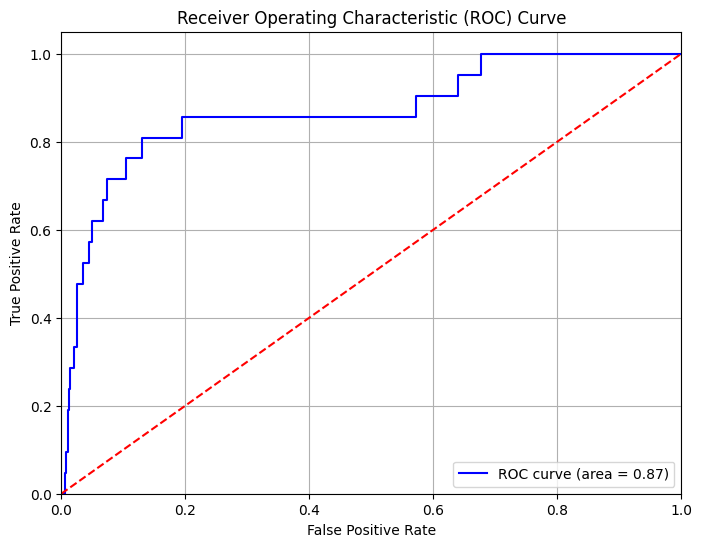

In [22]:
# draw auc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc 
fpr, tpr, thresholds = roc_curve(val_labels_binary, val_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

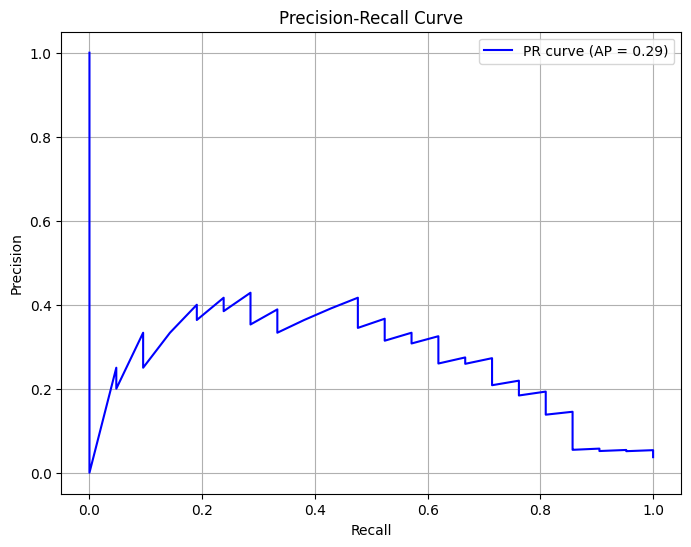

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(val_labels_binary, val_preds)
ap_score = average_precision_score(val_labels_binary, val_preds)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [24]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Step 1: Search for best threshold
thresholds = np.linspace(0, 1, 200)
f1_scores = [f1_score(val_labels_binary, val_preds > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold = {best_threshold:.2f}")

# Step 2: Apply threshold
val_preds_binary_best = (val_preds > best_threshold).astype(int)

# Step 3: Print classification report
print(classification_report(val_labels_binary, val_preds_binary_best))

Best threshold = 0.10
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       546
           1       0.40      0.48      0.43        21

    accuracy                           0.95       567
   macro avg       0.69      0.72      0.71       567
weighted avg       0.96      0.95      0.96       567



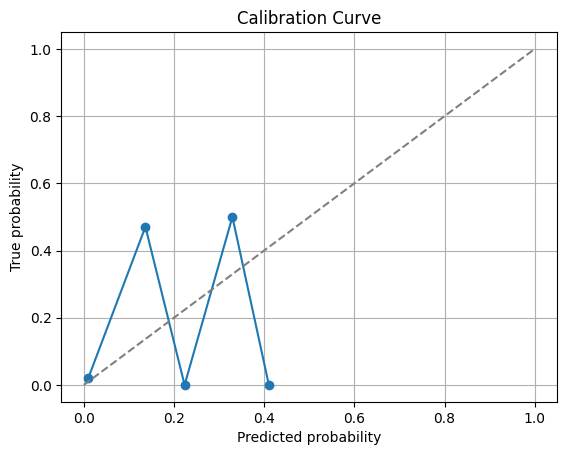

In [25]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(val_labels_binary, val_preds, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.grid()
plt.show()